<a href="https://colab.research.google.com/github/finntrinci/finntrinci.github.io/blob/main/Python/Disaster_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating Initial df from ReliefWeb API

In [1]:
import json
import requests
import pandas as pd
import numpy as np

In [2]:
#define URLs to pull data from
urls = ['https://api.reliefweb.int/v1/disasters?appname=rwint-user-0&profile=list&preset=latest&slim=1&query%5Bvalue%5D=type.id%3A%284672+OR+4611+OR+4648+OR+4624+OR+4618+OR+4719+OR+4930+OR+4656%29&query%5Boperator%5D=AND&limit=1000', 'https://api.reliefweb.int/v1/disasters?appname=rwint-user-0&profile=list&preset=latest&slim=1&query%5Bvalue%5D=type.id%3A%284672+OR+4611+OR+4648+OR+4624+OR+4618+OR+4719+OR+4930+OR+4656%29+AND+date.created%3A%5B1990-01-01+TO+2009-07-06%7D&query%5Boperator%5D=AND&limit=1000', 'https://api.reliefweb.int/v1/disasters?appname=rwint-user-0&profile=list&preset=latest&slim=1&query%5Bvalue%5D=type.id%3A%284672+OR+4611+OR+4648+OR+4624+OR+4618+OR+4719+OR+4930+OR+4656%29+AND+date.created%3A%5B1990-01-01+TO+1994-06-23%7D&query%5Boperator%5D=AND&limit=1000']
 
#now for each url in urls, want to get the data as json() and then create a file called request_{url_index}

for url_index, url in enumerate(urls):
    request = requests.get(url).json()
    with(open(f'request_{url_index}.json', 'w')) as out_file:
        json.dump(request, out_file, indent=4)

In [3]:
#collate the data from the json files we just requested into what we actually want.
#populating the dataframe row by row. Do this through defining a function 'process_json_file' which takes our json files containing the API calls,
#and appends them into one dataset (taking only the variables we want)

def process_json_file(disaster_dataframe:pd.DataFrame, file_path:str) -> pd.DataFrame:
    json_dict = json.load(open(file_path))
    index = len(disaster_dataframe.index)
#stating where we want each column to get its data from. name_date_tag is split into the name of the disaster and the
#date (month) of the disaster. [-1] is the right side, [0] is left side.
    for disaster in json_dict['data']:      
        id = disaster['id']
        name_date_tag :str = disaster['fields']['name']
        name = name_date_tag.split(' - ')[0]
        date = name_date_tag.split(' - ')[-1]
#need to further split the date variable up into year, some have a space inbetween the year and month, some have a dash
#since they are over 2 years, in this case since the disaster started in the first year, i use the first year.
        year_dash :str = date.split(' ')[-1]
        year = year_dash.split('-')[0]
        countries = disaster['fields']['country']
        types = disaster['fields']['type']
#since we are now returned a set of countries and types we need to then create a row for each country involved.
#do this through using their index, and keeping the id as an integer, name, date, and year but then assigning the country
#['name'] and the type ['name']
        for country in countries:
            for type in types:
                disaster_dataframe.loc[index] = [int(id), name, date, year, country['name'], type['name']]
                index +=1
    return disaster_dataframe

In [4]:

#now we want to put the data from our request json files into a disaster daraframe according to the function created above (process_json_file).

json_files = ['request_0.json','request_1.json','request_2.json']
 
disaster_dataframe = pd.DataFrame(columns=['ID', 'Name', 'Date', 'Year', 'Country', 'Type'])
 
for json_file in json_files:
    disaster_dataframe = process_json_file(disaster_dataframe, json_file)
 
disaster_dataframe.to_json('full_disaster_dataframe.json')
 
df = pd.read_json('full_disaster_dataframe.json')

In [5]:
df

,ID,Name,Date,Year,Country,Type
0,51427,South Africa: Floods,Dec 2022,2022,South Africa,Flood
1,51426,Bosnia and Herzegovina: Floods,Dec 2022,2022,Bosnia and Herzegovina,Flood
2,51426,Bosnia and Herzegovina: Floods,Dec 2022,2022,Bosnia and Herzegovina,Land Slide
3,51424,Malaysia: Floods and Landslides,Dec 2022,2022,Malaysia,Flood
4,51424,Malaysia: Floods and Landslides,Dec 2022,2022,Malaysia,Land Slide
...,...,...,...,...,...,...
4509,6028,Paraguay: Floods,Feb 1990,1990,Paraguay,Flood
4510,5376,Cook Islands: Cyclone Peni,Feb 1990,1990,Cook Islands,Tropical Cyclone
4511,5862,Madagascar: Cyclone,Jan 1990,1990,Madagascar,Tropical Cyclone
4512,6227,Sri Lanka: Floods,Jan 1990,1990,Sri Lanka,Flood


In [6]:
#
#
#
#
#
#Now, i want to give each country its code, so i can easily use this data with geojson for creating a map.
#first i want to see all the country names, for any strange naming, e.g. can immediately see Viet Nam and Bolivia (Plurinational State of)   
#how to deal with these?
disaster_dataframe['Country'].unique()

array(['South Africa', 'Bosnia and Herzegovina', 'Malaysia',
       'Democratic Republic of the Congo', 'Trinidad and Tobago',
       'Mongolia', 'Panama', 'Eswatini', 'Saint Lucia', 'Togo',
       'Ethiopia', 'Belize', 'Guatemala', 'Honduras', 'Mexico', 'Mali',
       'Philippines', 'Cameroon', 'Costa Rica', 'Benin', 'Thailand',
       'Viet Nam', 'El Salvador', 'Cayman Islands', 'Cuba', 'Jamaica',
       'United States of America', 'Cambodia', 'China',
       "Lao People's Democratic Republic (the)", 'Bulgaria', 'Bahamas',
       'Bermuda', 'British Virgin Islands', 'Dominican Republic',
       'Guyana', 'Puerto Rico (The United States of America)',
       'Turks and Caicos Islands', 'United States Virgin Islands',
       'Sierra Leone', 'Guinea', 'Senegal', 'Central African Republic',
       'Mauritania', 'Algeria', 'Chad', 'Sudan', 'Gambia', 'Sri Lanka',
       'Uganda', 'Nigeria', 'Iran (Islamic Republic of)', 'Yemen',
       "Côte d'Ivoire", 'Georgia', 'Pakistan', 'Kiribati', 'Tu

In [7]:
#there is a plugin called pycountry which has country names and iso codes to help create the new numeric variable.
!pip install pycountry
import pycountry


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 52.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=d74440e39e8a61d0f8c6cfcfe6d737bbdcf09515f26eace9fb68b536efc13eb9
  Stored in directory: /root/.cache/pip/wheels/e2/aa/0f/c224e473b464387170b83ca7c66947b4a7e33e8d903a679748
Successfully built pycountry


In [8]:
#list of countries whose names needed to be changed for the merge, code generated in excel using string functions.
df['Country'] = df['Country'].replace(["Lao People's Democratic Republic (the)"], "Lao People's Democratic Republic")
df['Country'] = df['Country'].replace(["Iran (Islamic Republic of)"], "Iran, Islamic Republic of")
df['Country'] = df['Country'].replace(["Bolivia (Plurinational State of)"], "Bolivia, Plurinational State of")
df['Country'] = df['Country'].replace(["Democratic Republic of the Congo"], "Congo, The Democratic Republic of the")
df['Country'] = df['Country'].replace(["China - Hong Kong (Special Administrative Region)"], "Hong Kong")
df['Country'] = df['Country'].replace(["China - Taiwan Province"], "Taiwan, Province of China")
df['Country'] = df['Country'].replace(["Northern Mariana Islands (The United States of America)"], "Northern Mariana Islands")
df['Country'] = df['Country'].replace(["New Caledonia (France)"], "New Caledonia")
df['Country'] = df['Country'].replace(["Niue (New Zealand)"], "Niue")
df['Country'] = df['Country'].replace(["Réunion (France)"], "Réunion")
df['Country'] = df['Country'].replace(["occupied Palestinian territory"], "Palestine, State of")
df['Country'] = df['Country'].replace(["Micronesia (Federated States of)"], "Micronesia")
df['Country'] = df['Country'].replace(["Venezuela (Bolivarian Republic of)"], "Venezuela, Bolivarian Republic of")
df['Country'] = df['Country'].replace(["the Republic of North Macedonia"], "North Macedonia")
df['Country'] = df['Country'].replace(["United States Virgin Islands"], "Virgin Islands, U.S.")
df['Country'] = df['Country'].replace(["Bonaire, Saint Eustatius and Saba (The Netherlands)"], "Bonaire, Sint Eustatius and Saba")
df['Country'] = df['Country'].replace(["Guadeloupe (France)"], "Guadeloupe")
df['Country'] = df['Country'].replace(["Martinique (France)"], "Martinique")
df['Country'] = df['Country'].replace(["Puerto Rico (The United States of America)"], "Puerto Rico")
df['Country'] = df['Country'].replace(["Saint Barthélemy (France)"], "Saint Barthélemy")
df['Country'] = df['Country'].replace(["Sint Maarten (The Netherlands)"], "Sint Maarten (Dutch part)")
df['Country'] = df['Country'].replace(["Saint Martin (France)"], "Saint Martin (French part)")
df['Country'] = df['Country'].replace(["Aruba (The Netherlands)"], "Aruba")
df['Country'] = df['Country'].replace(["Curaçao (The Netherlands)"], "Curaçao")
df['Country'] = df['Country'].replace(["Wallis and Futuna (France)"], "Wallis and Futuna")
df['Country'] = df['Country'].replace(["Türkiye"], "Turkey")
df['Country'] = df['Country'].replace(["Madeira (Portugal)"], "Portugal")
df['Country'] = df['Country'].replace(["French Polynesia (France)"], "French Polynesia")
df['Country'] = df['Country'].replace(["Netherlands Antilles (The Netherlands)"], "Curaçao")
df['Country'] = df['Country'].replace(["Democratic People's Republic of Korea"], "Korea, Democratic People's Republic of")
df['Country'] = df['Country'].replace(["Republic of Korea"], "Korea, Republic of")
df['Country'] = df['Country'].replace(["United States of America"], "United States")
df['Country'] = df['Country'].replace(["United Kingdom of Great Britain and Northern Ireland"], "United Kingdom")
df['Country'] = df['Country'].replace(["United Republic of Tanzania"], "Tanzania, United Republic of")
df['Country'] = df['Country'].replace(["Micronesia"], "Micronesia, Federated States of")
df['Country'] = df['Country'].replace(["Moldova"], "Moldova, Republic of")
df['Country'] = df['Country'].replace(["British Virgin Islands"], "Virgin Islands, British")

In [9]:

#
#Trying to match countries based on current country name, doesn't match all and instead says 'not founded'.
#Needed to rename a set of countries so they can be properly matched with their numeric codes.


def findCountry (country_name):
    try:
        return pycountry.countries.get(name=country_name).numeric
    except:
        return ("not founded")
df['country_numeric'] = df.apply(lambda row: findCountry(row.Country) , axis = 1)

In [10]:
#then i can see how countries are called in pycountry using this.
#interestingly, Madeira are called a country in my dataset, but in pycountry don't have an individual entry.
pycountry.countries.lookup("092")

Country(alpha_2='VG', alpha_3='VGB', flag='🇻🇬', name='Virgin Islands, British', numeric='092', official_name='British Virgin Islands')

In [11]:
#alternative matching method which uses 'fuzzy matching' instead of exact matching.
#returns more matches for countries, but some inaccurate e.g. matches Martinique to French iso numeric code.

# def do_fuzzy_search(country):
#     try:
#         result = pycountry.countries.search_fuzzy(country)
#     except Exception:
#         return ("not founded")
#     else:
#         return result[0].numeric

# iso_map = {country: do_fuzzy_search(country) for country in df["Country"].unique()}
# df["country_code"] = df["Country"].map(iso_map)

In [12]:
df

,ID,Name,Date,Year,Country,Type,country_numeric
0,51427,South Africa: Floods,Dec 2022,2022,South Africa,Flood,710
1,51426,Bosnia and Herzegovina: Floods,Dec 2022,2022,Bosnia and Herzegovina,Flood,070
2,51426,Bosnia and Herzegovina: Floods,Dec 2022,2022,Bosnia and Herzegovina,Land Slide,070
3,51424,Malaysia: Floods and Landslides,Dec 2022,2022,Malaysia,Flood,458
4,51424,Malaysia: Floods and Landslides,Dec 2022,2022,Malaysia,Land Slide,458
...,...,...,...,...,...,...,...
4509,6028,Paraguay: Floods,Feb 1990,1990,Paraguay,Flood,600
4510,5376,Cook Islands: Cyclone Peni,Feb 1990,1990,Cook Islands,Tropical Cyclone,184
4511,5862,Madagascar: Cyclone,Jan 1990,1990,Madagascar,Tropical Cyclone,450
4512,6227,Sri Lanka: Floods,Jan 1990,1990,Sri Lanka,Flood,144


In [13]:
#here i create a new dataframe which shows disaster quantity by country and type per year.

disaster_country_type_year = df.groupby(['Country', 'country_numeric', 'Type', 'Year'],as_index=False).count()
disaster_country_type_year = disaster_country_type_year.rename(columns={'Name':'Count'})
disaster_country_type_year = disaster_country_type_year.drop(columns=['ID', 'Date'], axis=1)
disaster_country_type_year

,Country,country_numeric,Type,Year,Count
0,Afghanistan,004,Cold Wave,2015,1
1,Afghanistan,004,Cold Wave,2017,1
2,Afghanistan,004,Drought,2000,2
3,Afghanistan,004,Drought,2001,3
4,Afghanistan,004,Drought,2011,1
...,...,...,...,...,...
3465,Zimbabwe,716,Land Slide,2019,1
3466,Zimbabwe,716,Tropical Cyclone,2017,1
3467,Zimbabwe,716,Tropical Cyclone,2019,1
3468,Zimbabwe,716,Tropical Cyclone,2021,1


In [14]:
#Drop types which I'm not considering, these were only taken by miatske from expanding arrays of disaster types:
disaster_country_type_year.drop(disaster_country_type_year[disaster_country_type_year['Type'] == 'Land Slide'].index, inplace = True)
disaster_country_type_year.drop(disaster_country_type_year[disaster_country_type_year['Type'] == 'Snow Avalanche'].index, inplace = True)
disaster_country_type_year.drop(disaster_country_type_year[disaster_country_type_year['Type'] == 'Technological Disaster'].index, inplace = True)
disaster_country_type_year.drop(disaster_country_type_year[disaster_country_type_year['Type'] == 'Other'].index, inplace = True)
disaster_country_type_year.drop(disaster_country_type_year[disaster_country_type_year['Type'] == 'Earthquake'].index, inplace = True)
disaster_country_type_year.drop(disaster_country_type_year[disaster_country_type_year['Type'] == 'Mud Slide'].index, inplace = True)


In [15]:
disaster_country_type_year

,Country,country_numeric,Type,Year,Count
0,Afghanistan,004,Cold Wave,2015,1
1,Afghanistan,004,Cold Wave,2017,1
2,Afghanistan,004,Drought,2000,2
3,Afghanistan,004,Drought,2001,3
4,Afghanistan,004,Drought,2011,1
...,...,...,...,...,...
3464,Zimbabwe,716,Flood,2021,1
3466,Zimbabwe,716,Tropical Cyclone,2017,1
3467,Zimbabwe,716,Tropical Cyclone,2019,1
3468,Zimbabwe,716,Tropical Cyclone,2021,1


In [16]:
#define every country code within my EPI dataset (copy and pasted from df['code'].unique() line):
all_country_code = ['004', '024', '008', '784', '032', '051', '028', '036', '040',
       '031', '108', '056', '204', '854', '050', '100', '048', '044',
       '070', '112', '084', '068', '076', '052', '096', '064', '072',
       '140', '124', '756', '152', '156', '384', '120', '180', '178',
       '170', '174', '132', '188', '192', '196', '203', '276', '262',
       '212', '208', '214', '012', '218', '818', '232', '724', '233',
       '231', '246', '242', '250', '583', '266', '826', '268', '288',
       '324', '270', '624', '226', '300', '308', '320', '328', '340',
       '191', '332', '348', '360', '356', '372', '364', '368', '352',
       '376', '380', '388', '400', '392', '398', '404', '417', '116',
       '296', '410', '414', '418', '422', '430', '662', '144', '426',
       '440', '442', '428', '504', '498', '450', '462', '484', '584',
       '807', '466', '470', '104', '499', '496', '508', '478', '480',
       '454', '458', '516', '562', '566', '558', '528', '578', '524',
       '554', '512', '586', '591', '604', '608', '598', '616', '620',
       '600', '634', '642', '643', '646', '682', '729', '686', '702',
       '090', '694', '222', '688', '678', '740', '703', '705', '752',
       '748', '690', '148', '768', '764', '762', '795', '626', '776',
       '780', '788', '792', '158', '834', '800', '804', '858', '840',
       '860', '670', '862', '704', '548', '882', '710', '894', '716']

In [17]:
#Making an empty dataframe to match my data onto. Means i will have 0 rows instead of non-existent rows for 0 years.

data = []

for c in all_country_code:
  for t in range(1990,2023):
      data.append({'country_numeric':c, 'Year':t})


In [18]:
#This line joins the disaster data onto our empty frame called 'data' by matching their country numeric and year.
df_n = pd.DataFrame(data).set_index(['country_numeric', 'Year']).join(disaster_country_type_year.set_index(['country_numeric', 'Year']))


In [19]:
#to not have double indexes, we want to reset the index.
df_n = df_n.reset_index()
df_n.head(2)

,country_numeric,Year,Country,Type,Count
0,004,1990,NaN,NaN,NaN
1,004,1991,Afghanistan,Flood,1.0


In [20]:
#Now we have missing country names, but the country codes are present. We can do a similar function to above to
#get all country names to show up using their country numeric.
#Needed to add the str() function since pycountry stores the numeric codes as string rather than float.

def findName(country_numeric):
    try:
        return pycountry.countries.get(numeric=str(country_numeric)).name
    except:
        return ("not founded")
df_n['country_name'] = df_n.apply(lambda row: findName(row.country_numeric) , axis = 1)


In [21]:
#can now drop the old country name variable, and replace missing count rows with 0s.
df_n2 = df_n.drop('Country', axis=1)
df_n2['Count'] = df_n2['Count'].fillna(0)

In [22]:
df_n2

,country_numeric,Year,Type,Count,country_name
0,004,1990,NaN,0.0,Afghanistan
1,004,1991,Flood,1.0,Afghanistan
2,004,1992,Flash Flood,1.0,Afghanistan
3,004,1993,NaN,0.0,Afghanistan
4,004,1994,NaN,0.0,Afghanistan
...,...,...,...,...,...
6837,894,2019,NaN,0.0,Zambia
6838,894,2020,Flash Flood,1.0,Zambia
6839,894,2020,Flood,1.0,Zambia
6840,894,2021,NaN,0.0,Zambia


## For the year slider map

In [ ]:
#For map(year_slider) we want the data to be by country and year. So here we count across types:

disaster_country_year = df_n2.groupby(['country_name', 'country_numeric', 'Year'],as_index=False).sum('Count')
disaster_country_year = disaster_country_year.drop('index', axis=1)
disaster_country_year

In [ ]:
#Exporting our Year Slider data:
import json
exported_values = list(disaster_country_year.T.to_dict().values())
#then take this list and write it as a json file.
open('disaster_country_year.json', 'w').write(json.dumps(exported_values))

508707

## For Trellis of Distributions

In [73]:
#New df where we have no '0' observations, all types are properly assigned.
df_type = df_n2[df_n2['Type'].notna()]

In [ ]:
#For the Trellis Distribution, we want the data by country and disaster type
#We want to group some disasters together, i.e. tropical and extratropical cyclone
df_type.loc[df_type['Type'] == "Flash Flood", 'Type'] = "Flood"
df_type.loc[df_type['Type'] == "Storm Surge", 'Type'] = "Tropical Cyclone"
df_type.loc[df_type['Type'] == "Extratropical Cyclone", 'Type'] = "Tropical Cyclone"
df_type.loc[df_type['Type'] == "Wild Fire", 'Type'] = "Fire"
df_type.loc[df_type['Type'] == "Cold Wave", 'Type'] = "Cold/Heat Wave"
df_type.loc[df_type['Type'] == "Heat Wave", 'Type'] = "Cold/Heat Wave"


df_type['Type'].unique()

In [79]:
#aggregating by country and type of disaster.
disaster_country_type = df_type.groupby(['country_name', 'country_numeric', 'Type'],as_index=False).sum('Count')
disaster_country_type = disaster_country_type.drop('Year', axis=1)


In [ ]:
disaster_country_type

In [80]:
#Erasing 2 outlier observations so that the graph is readable.
disaster_country_type.drop(disaster_country_type[disaster_country_type.Count > 62].index, inplace=True)


In [82]:
#Exporting our Trellis Distribution data:
import json
exported_values = list(disaster_country_type.T.to_dict().values())
#then take this list and write it as a json file.
open('disaster_country_type(1).json', 'w').write(json.dumps(exported_values))

40990

## For line chart

In [ ]:
##Creating just the sum of disasters by year to create a line chart
disaster_year = df_n2.groupby(['Year'],as_index=False).sum('Count')

disaster_year['Count'] = disaster_year['Count'].rolling(1).mean()
dissaster_year= disaster_year.rename(columns = {"Count":"Count_annual"}, inplace = True)
disaster_year = disaster_year.fillna("")
disaster_year




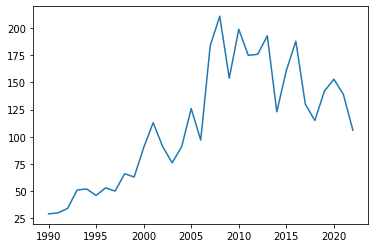

In [ ]:
#Summing over the years gives large variation year-on-year, so these plots are used to choose the degree of MA(x) for the data.
import matplotlib.pyplot as plt

plt.plot(disaster_year['Year'], disaster_year['Count_annual'])
plt.show()

In [ ]:
import json
exported_values = list(disaster_year.T.to_dict().values())
#then take this list and write it as a json file.
open('disaster_year.json', 'w').write(json.dumps(exported_values))

1338

## Adding in clustering results

In [ ]:
import pandas as pd
import numpy as np
import requests


In [16]:
df_cluster = pd.read_json('https://raw.githubusercontent.com/finntrinci/finntrinci.github.io/main/data/EPI2022_clustered(c_6).json')

In [17]:
#Creatinga 'helper' for country clustering. Gives the country (name, code, iso) and its respective clustering, indexed by country (to not have repeats).

cluster_helper = df_cluster[['country', 'code', 'iso', 'cluster']].drop_duplicates().set_index('country')
cluster_helper.dtypes

code        int64
iso        object
cluster     int64
dtype: object

In [18]:
#need country_numeric as int64 to merge properly
df_n2['country_numeric'] = df_n2['country_numeric'].astype(int)
df_merge = df_n2.rename(columns ={'country_numeric':'code'})

In [ ]:
df_merge.dtypes

In [19]:
#Need to run above code to get df_n2
df_dis_cluster = pd.merge(df_merge, cluster_helper, on = 'code', how='left')

In [20]:
#reformat country codes as 3 digits
df_dis_cluster['code'] = df_dis_cluster['code'].astype(str).str.zfill(3)


In [ ]:
#exporting
import json
exported_values = list(df_dis_cluster.T.to_dict().values())
#then take this list and write it as a json file.
open('dis_cluster_type.json', 'w').write(json.dumps(exported_values))

814846

In [22]:
#since we have a lot of rows with 0 counts, we should drop all observations with NaN type since these were all
#generated earlier. 

df_dis_cluster2 = df_dis_cluster[df_dis_cluster['Type'].notna()]

#this data will be presented on aggregates, so the type of disaster is not important, just the incidence
#sum types by country and year.

df_dis_cluster2 = df_dis_cluster2.groupby(['Year', 'code', 'country_name', 'iso', 'cluster'],as_index=False).sum('Count')
df_dis_cluster2

,Year,code,country_name,iso,cluster,Count
0,1990,084,Belize,BLZ,6,1.0
1,1990,144,Sri Lanka,LKA,2,1.0
2,1990,156,China,CHN,1,2.0
3,1990,192,Cuba,CUB,4,1.0
4,1990,214,Dominican Republic,DOM,2,1.0
...,...,...,...,...,...,...
1921,2022,788,Tunisia,TUN,4,1.0
1922,2022,800,Uganda,UGA,2,1.0
1923,2022,840,United States,USA,5,1.0
1924,2022,862,"Venezuela, Bolivarian Republic of",VEN,1,1.0


In [ ]:
import json
exported_values = list(df_dis_cluster2.T.to_dict().values())
#then take this list and write it as a json file.
open('dis_cluster_notype.json', 'w').write(json.dumps(exported_values))

198288

In [25]:
#Also exporting the cluster helper to have as a live json file on github.
import json
#resetting index to have country column
cluster_helper = cluster_helper.reset_index(level=0)

exported_values = list(cluster_helper.T.to_dict().values())
#then take this list and write it as a json file.
open('cluster_helper.json', 'w').write(json.dumps(exported_values))

11964

## Disasters per cluster, 2007 - 2022

In [ ]:
#Take dataset by countries, type, year, and count (df_n2):
#This dataframe has type = NaN for years with 0 'count'. Can 'drop' these rows.

df_n2_nona = df_n2[df_n2['Type'].notna()]
df_n2_nona

In [24]:
#Now restrict this to only be disassters from 2007 - 2022 (since comparing EPI in 2012 and 2022, so prior data not relevant)
df_gap = df_n2_nona[df_n2_nona['Year'] >= 2007]

In [ ]:
#Since we only want a few disaster types, can group together similar disasters, i.e. flood & flash flood.
df_gap.loc[df_gap['Type'] == "Flash Flood", 'Type'] = "Flood"
df_gap.loc[df_gap['Type'] == "Storm Surge", 'Type'] = "Tropical Cyclone"
df_gap.loc[df_gap['Type'] == "Extratropical Cyclone", 'Type'] = "Tropical Cyclone"
df_gap.loc[df_gap['Type'] == "Wild Fire", 'Type'] = "Fire"
df_gap.loc[df_gap['Type'] == "Cold Wave", 'Type'] = "Cold/Heat Wave"
df_gap.loc[df_gap['Type'] == "Heat Wave", 'Type'] = "Cold/Heat Wave"
df_gap['Type'].unique()

In [ ]:
#Add results of clustering using the sane cluster 'helper' dataframe from above.
df_cluster = pd.read_json('https://raw.githubusercontent.com/finntrinci/finntrinci.github.io/main/data/EPI2022_clustered(c_6).json')
cluster_helper = df_cluster[['country', 'code', 'iso', 'cluster']].drop_duplicates().set_index('country')

#making country_numeric integer
df_gap['country_numeric'] = df_gap['country_numeric'].astype(int)
df_gap_merge = df_gap.rename(columns ={'country_numeric':'code'})

#now mergine
df_gap_cluster = pd.merge(df_gap_merge, cluster_helper, on = 'code', how='left')

#setting the country codes back to 3 digits:
df_gap_cluster['code'] = df_gap_cluster['code'].astype(str).str.zfill(3)
df_gap_cluster

In [27]:
#now we want to count the number of countries in each cluster, so we can have 'disasters per country' for each cluster.
cluster_sizes = cluster_helper['cluster'].value_counts()

In [28]:
#sum disasters across clusters
df_gap_cluster_counts = df_gap_cluster.groupby(['cluster', 'Type'], as_index=False).sum('Count')


In [29]:
df_gap_cluster_counts = df_gap_cluster_counts.drop('Year', axis=1)

In [ ]:
#Adding a 'total' row for each cluster, need to first create a dataframe to append
df_gap_cluster_totals = df_gap_cluster_counts.groupby (['cluster'], as_index=False).sum('Count')
df_gap_cluster_totals['Type'] = ['Total', 'Total', 'Total', 'Total', 'Total', 'Total']
df_gap_cluster_totals

In [ ]:
#appending this totals dataset onto the count one and sorting by cluster.
df_gap_cluster_all_counts = df_gap_cluster_counts.append(df_gap_cluster_totals)
df_gap_cluster_all_counts.sort_values(['cluster', 'Type'])

In [32]:
#creating 'count per country' column using the cluster_sizes array we created earlier
cluster_size = pd.DataFrame(cluster_sizes).reset_index().rename({"index":"cluster", "cluster":"n_countries"}, axis=1)


In [ ]:
#appending cluster_size as new column and then creating the count per country column.
df_gap_cluster_complete = pd.merge(df_gap_cluster_all_counts, cluster_size, on = 'cluster', how='left')
df_gap_cluster_complete['Count_per_country'] = df_gap_cluster_complete['Count']/df_gap_cluster_complete['n_countries']

In [34]:
#adding the average EPI change column onto this, generated in 'Comparing 2012 and 2022 Data' section of EPI notebook
df_epi_diff = pd.read_json('https://raw.githubusercontent.com/finntrinci/finntrinci.github.io/main/data/EPI_cluster_avg_diff.json')

In [35]:
#adding the average differences column
df_gap_cluster_complete2 = pd.merge(df_gap_cluster_complete, df_epi_diff, on = ['cluster'], how='left')


In [ ]:
df_gap_cluster_complete2

In [36]:
#getting list of types.
df_gap_cluster_complete2['Type'].unique()

array(['Cold/Heat Wave', 'Drought', 'Fire', 'Flood', 'Severe Local Storm',
       'Tropical Cyclone', 'Total'], dtype=object)

In [37]:
#Need observations for each cluster and disaster type, so 0 rows instead of non-existent rows.
data = []

for c in df_gap_cluster_complete2['cluster'].unique():
  for j in df_gap_cluster_complete2['Type'].unique():
    for t in df_gap_cluster_complete2['year']:
      data.append({'cluster':c, 'Type':j, 'year':t})


pd.DataFrame(data)
df_gap_cluster_very_complete = pd.DataFrame(data).set_index(['cluster', 'Type', 'year']).join(df_gap_cluster_complete2.set_index(['cluster', 'Type', 'year'])).fillna(0).reset_index()

In [38]:
#drop the duplicates created through this.
df_gap_cluster_very_complete = df_gap_cluster_very_complete.drop_duplicates()

In [39]:
#issue: instead of having descriptive data (1dim_cluster etc.) we have 0, need to re-merge with original data to have this for each row
#restricting to only columns we want.
varlist = ['cluster', 'year', 'n_countries', '1dim_cluster', 'diff_avg', 'positive']
df_final_merge = df_gap_cluster_complete2[varlist]

In [40]:
df_final_merge = df_final_merge.drop_duplicates()

In [41]:
df_gap_cluster_super_complete = pd.merge(df_gap_cluster_very_complete, df_final_merge, on = ['cluster', 'year'], how='left')

In [42]:
#cleaning: getting rid of columns
df_gap_cluster_super_complete = df_gap_cluster_super_complete.drop(['n_countries_x', '1dim_cluster_x', 'diff_avg_x', 'n_countries_x', 'positive_x'], axis=1)
#cleaning: renaming columnd
df_gap_cluster_super_complete = df_gap_cluster_super_complete.rename({'n_countries_y':'n_countries', '1dim_cluster_y':'1dim_cluster', 'diff_avg_y':'diff_avg', 'positive_y':'positive'}, axis=1)

In [47]:
df_gap_cluster_super_complete

,cluster,Type,year,Count,Count_per_country,n_countries,1dim_cluster,diff_avg,positive
0,1,Cold/Heat Wave,2012,4.0,0.137931,29,-16.241631,29.411336,1
1,1,Cold/Heat Wave,2022,4.0,0.137931,29,13.169705,29.411336,1
2,1,Drought,2012,20.0,0.689655,29,-16.241631,29.411336,1
3,1,Drought,2022,20.0,0.689655,29,13.169705,29.411336,1
4,1,Fire,2012,8.0,0.275862,29,-16.241631,29.411336,1
...,...,...,...,...,...,...,...,...,...
79,6,Severe Local Storm,2022,5.0,0.277778,18,-27.147355,0.766087,1
80,6,Total,2012,192.0,10.666667,18,-27.913441,0.766087,1
81,6,Total,2022,192.0,10.666667,18,-27.147355,0.766087,1
82,6,Tropical Cyclone,2012,64.0,3.555556,18,-27.913441,0.766087,1


In [48]:
#issue with final graph since cluster 6 and 5 had exact same fires per country, marginal change (0.0000001 increase)
# to fix this
df_gap_cluster_super_complete.at[74, 'Count_per_country'] = 0.1111112
df_gap_cluster_super_complete.at[75, 'Count_per_country'] = 0.1111112

In [50]:
#export dataset for use in vega-lite
import json
exported_values = list(df_gap_cluster_super_complete.T.to_dict().values())
open('dis_epi_clustered_compare.json', "w").write(json.dumps(exported_values))

17448